#**RGB-> 0.6**

#**XYZ-> 0.4** 

In [1]:
!pip install -q tensorflow-io
import os
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras.layers import  Lambda, Input, Dense, \
                         Dropout
from keras.layers.merge import Concatenate
from tensorflow.keras.models import Model, Sequential 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow_hub as hub

from utils import DatasetBuilder ,EvaluateModel ,ModelUtils

     |████████████████████████████████| 25.9 MB 1.2 MB/s 


In [2]:
DATASET_PATH = os.path.join(os.getcwd(),'drive',"MyDrive", 'Car-Color-Recognition','CarDS')
BATCH_SIZE = 32
IMAGE_SIZE = (300 ,300)
colorspace = "RGB_XYZ_2"
model_name = "RGB_XYZ_2"
dsBuilder = DatasetBuilder(DATASET_PATH ,image_size = IMAGE_SIZE ,batch_size = BATCH_SIZE)
train_ds , val_ds = dsBuilder.create('train') , dsBuilder.create('val')
class_names=train_ds.class_names
NUM_CLASSES = len(class_names)

class_weights = dsBuilder.get_class_weights(train_ds)

for key ,value in class_weights.items() : print("{} : {}".format(class_names[key], value.round(3)))

Found 19171 files belonging to 16 classes.
Found 3491 files belonging to 16 classes.
beige : 1.161
black : 0.97
blue : 1.087
brown : 1.14
cream : 2.014
crimson : 1.945
gold : 2.147
green : 1.325
grey : 0.873
navy-blue : 2.031
orange : 1.39
red : 1.152
silver : 1.268
titanium : 1.997
white : 0.209
yellow : 1.297


## **Rate = 0.6**

In [3]:
rate = 0.6
def combine_rgb_xyz(rgb_image):
  xyz_image = DatasetBuilder.rgb2xyz(rgb_image)
  return (rgb_image*rate)+(xyz_image*(1-rate))

In [4]:
train_ds = (
    train_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    map(lambda img ,lbl : (combine_rgb_xyz(img) ,lbl) ,num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

val_ds = (
    val_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    map(lambda img ,lbl : (combine_rgb_xyz(img) ,lbl) ,num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

In [ ]:
augmentation = Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.05),
    ]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

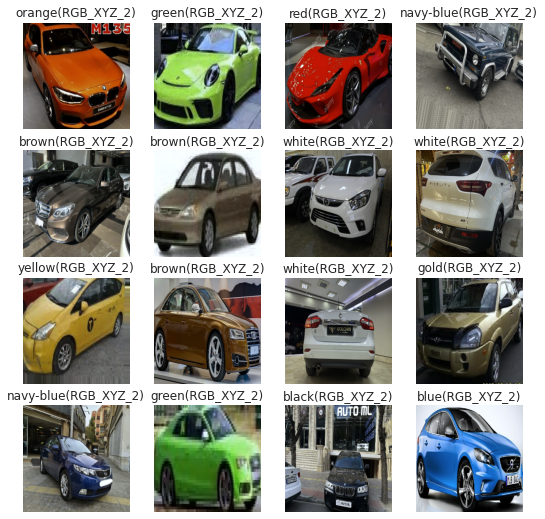

In [ ]:
fig=plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(16):
      plt.subplot(4, 4, i + 1)
      image = tf.expand_dims(images[i] ,axis=0)
      lbl = "{}({})".format(class_names[labels[i].numpy().argmax()] , colorspace )
      plt.imshow(tf.squeeze(image))
      plt.title(lbl)
      plt.axis("off")
    break

In [ ]:
do_fine_tuning = True

url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2"
base_model = hub.KerasLayer(url,trainable=do_fine_tuning)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    augmentation,
    base_model,
    Dense(400),
    Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES,activation = "softmax", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 dense (Dense)               (None, 400)               614800    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                6416      
                                                                 
Total params: 13,551,838
Trainable params: 13,442,622
Non-trainable params: 109,216
_________________________________________________________________


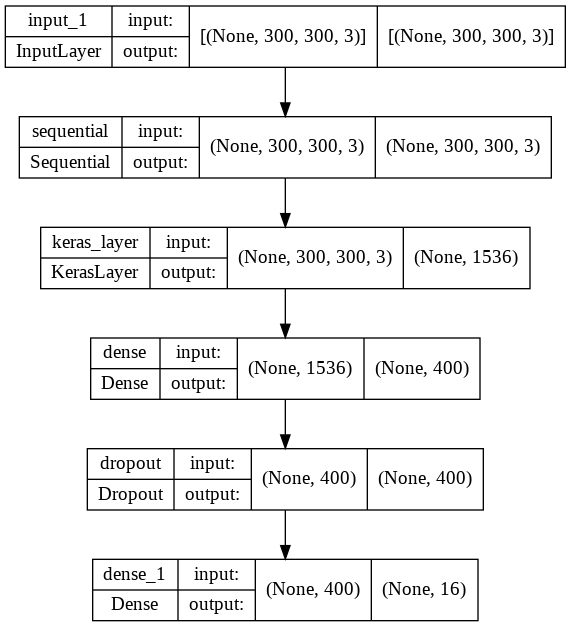

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_RGB_XYZ_2.png', show_shapes=True)

In [ ]:
model_utils = ModelUtils(model_name ,"HUB")
run_index = 1
callbacks= model_utils.get_callbacks(run_index = run_index )
model = model_utils.make_or_restore_model(model,"SGD",lr = 1e-2)
n_epochs = 50
print("{}: ".format(model_name))
model.fit(train_ds,
          validation_data=val_ds,
          epochs=n_epochs,
          callbacks=callbacks,
          class_weight = class_weights
          )   

Creating a new model
RGB_XYZ_2: 
Epoch 1/50
600/600 [==============================] - ETA: 0s - loss: 0.8800 - accuracy: 0.7296
Epoch 1: val_loss improved from inf to 0.95613, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_XYZ_2/_1.h5
600/600 [==============================] - 2645s 4s/step - loss: 0.8800 - accuracy: 0.7296 - val_loss: 0.9561 - val_accuracy: 0.7138 - lr: 0.0100
Epoch 2/50
600/600 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.8410
Epoch 2: val_loss improved from 0.95613 to 0.80288, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_XYZ_2/_2.h5
600/600 [==============================] - 396s 657ms/step - loss: 0.4885 - accuracy: 0.8410 - val_loss: 0.8029 - val_accuracy: 0.7694 - lr: 0.0100
Epoch 3/50
600/600 [==============================] - ETA: 0s - loss: 0.3773 - accuracy: 0.8786
Epoch 3: val_loss improved from 0.80288 to 0.58004, saving model to /content/drive/MyDr

In [5]:
run_index = 1
model_utils = ModelUtils(model_name ,"HUB")
model = keras.models.load_model('/content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB_XYZ_2/_5.h5' ,custom_objects={'KerasLayer':hub.KerasLayer})

In [6]:
model_utils.save_model_and_history(model ,run_index)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Models/RGB_XYZ_2/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Models/RGB_XYZ_2/1/assets


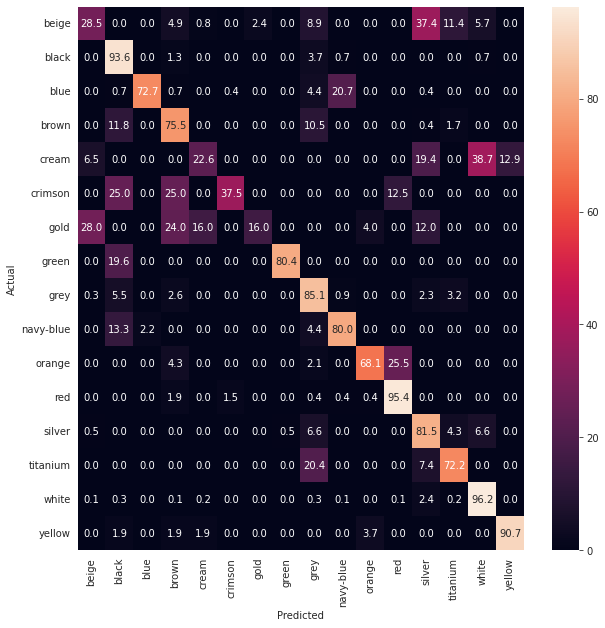

In [7]:
eval = EvaluateModel(model ,val_ds ,class_names,"RGB_XYZ_2")
eval.plot_confusion()

In [8]:
eval.report()

Report CSV file added to logs .


,precision,recall,f1-score,support
beige,0.729167,0.284553,0.409357,123.000000
black,0.797143,0.936242,0.861111,298.000000
blue,0.995025,0.727273,0.840336,275.000000
brown,0.824885,0.755274,0.788546,237.000000
cream,0.437500,0.225806,0.297872,31.000000
crimson,0.375000,0.375000,0.375000,8.000000
gold,0.571429,0.160000,0.250000,25.000000
green,0.973684,0.804348,0.880952,46.000000
grey,0.760417,0.851312,0.803301,343.000000
navy-blue,0.360000,0.800000,0.496552,45.000000
